Загрузка необходимых библиотек

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

Основной код для анализа групп пациентов с синдромом МКС и при здоровом когнитивном старении (n=60)

Анализ группы MCI...

Проверка нормальности для группы MCI:
total_words: W = 0.895, p = 0.0001 (не нормальное)
memory_complaints_ratio: W = 0.534, p = 0.0000 (не нормальное)
hesitations_ratio: W = 0.867, p = 0.0000 (не нормальное)


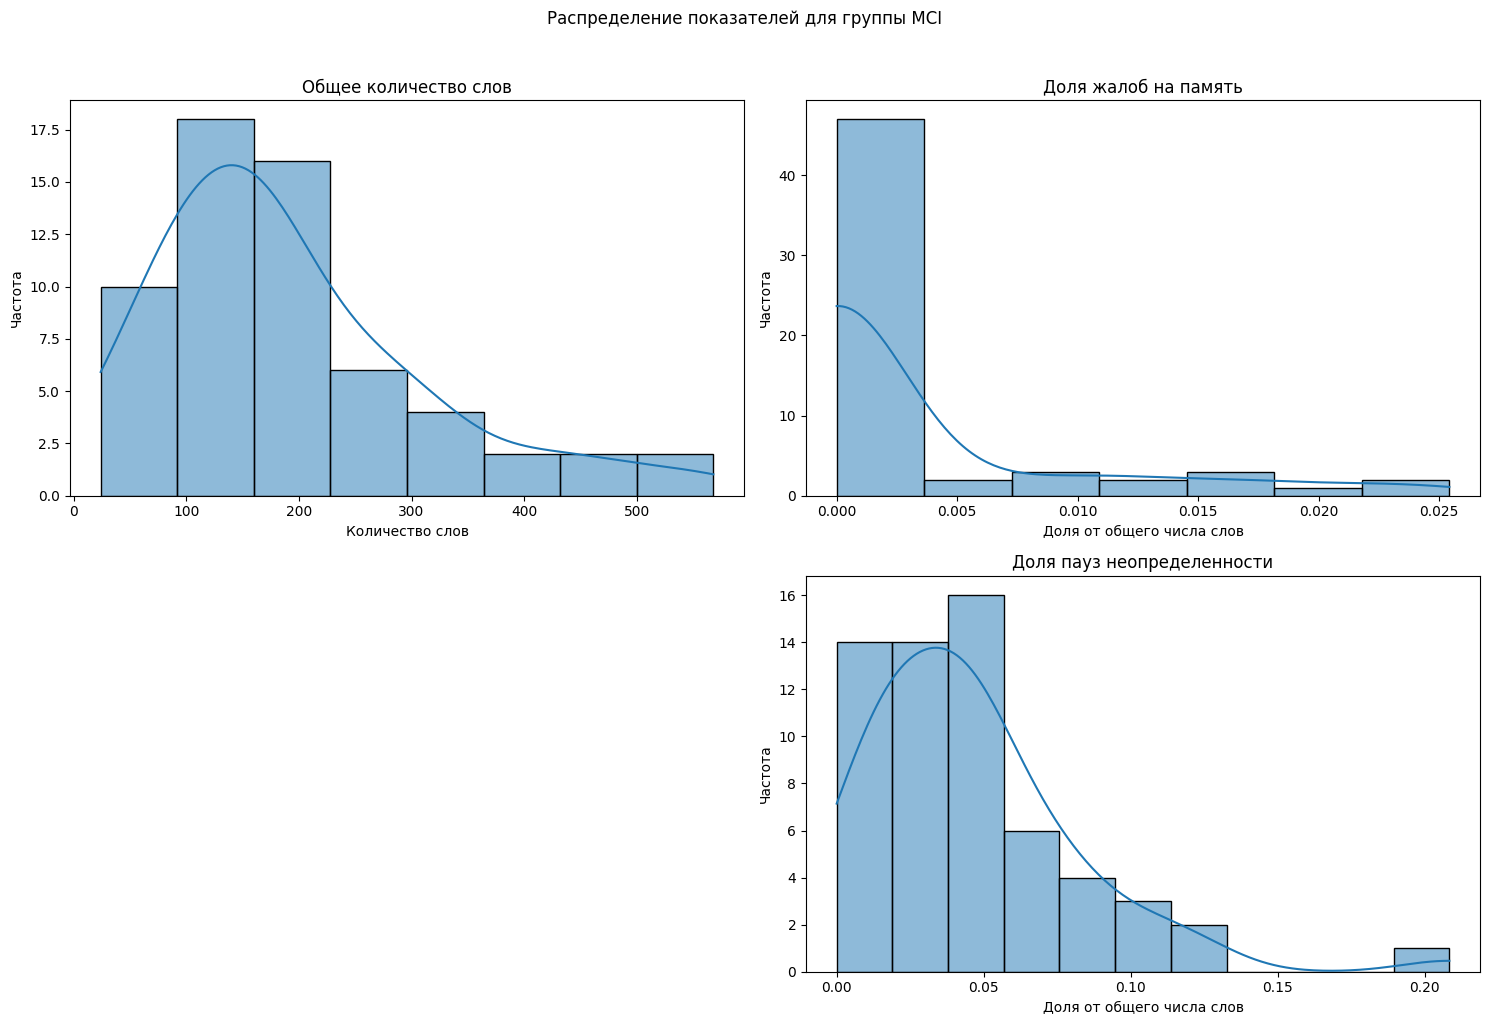


Анализ контрольной группы...

Проверка нормальности для группы Control:
total_words: W = 0.902, p = 0.0002 (не нормальное)
memory_complaints_ratio: W = 0.417, p = 0.0000 (не нормальное)
hesitations_ratio: W = 0.952, p = 0.0188 (не нормальное)


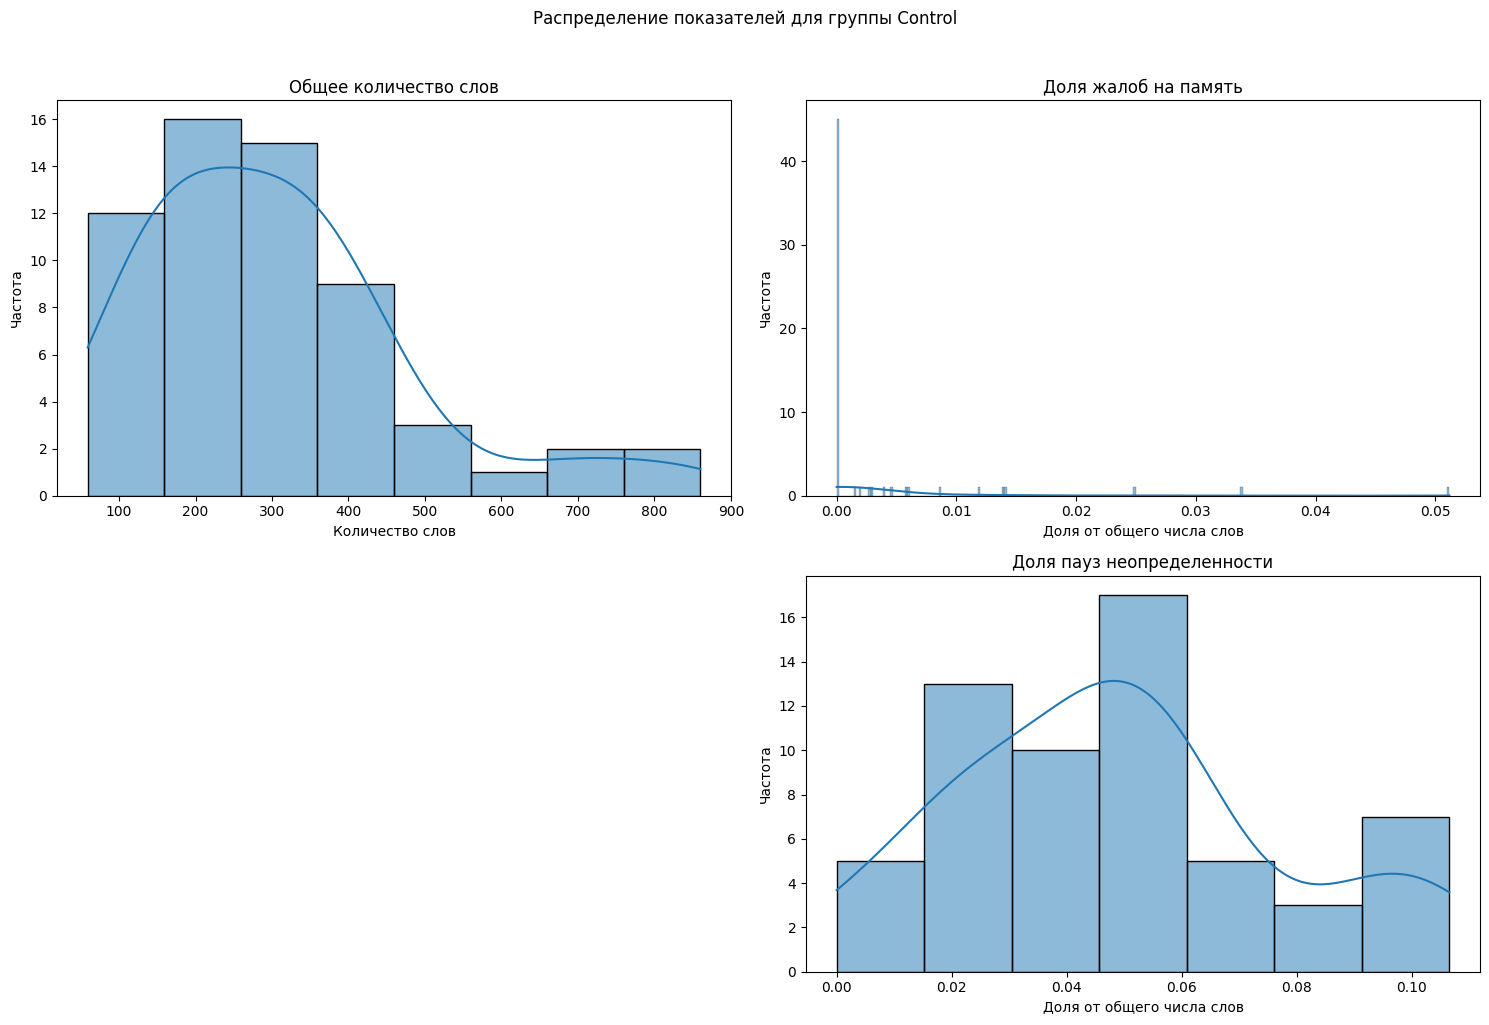


Категория: memory_complaints
MCI (n=60): среднее = 0.0031 ± 0.0066
Контроль (n=60): среднее = 0.0031 ± 0.0088
U-тест: статистика = 1773.500, p-value = 0.8539
Различия не значимы

Категория: hesitations
MCI (n=60): среднее = 0.0456 ± 0.0369
Контроль (n=60): среднее = 0.0484 ± 0.0282
U-тест: статистика = 1575.500, p-value = 0.2396
Различия не значимы


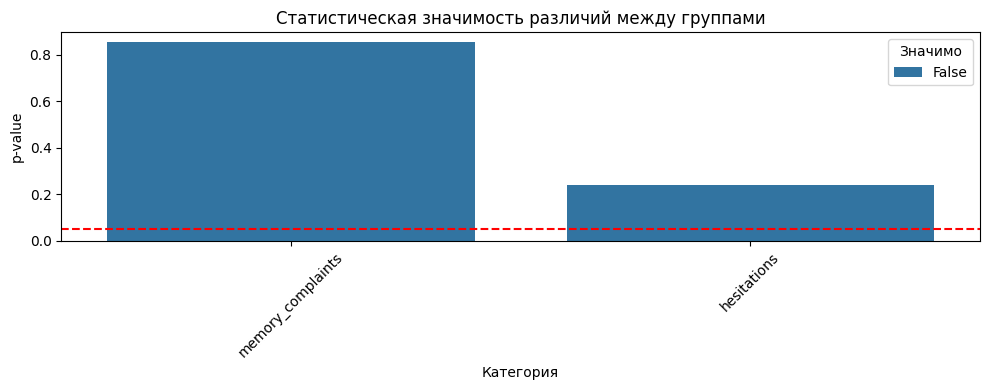

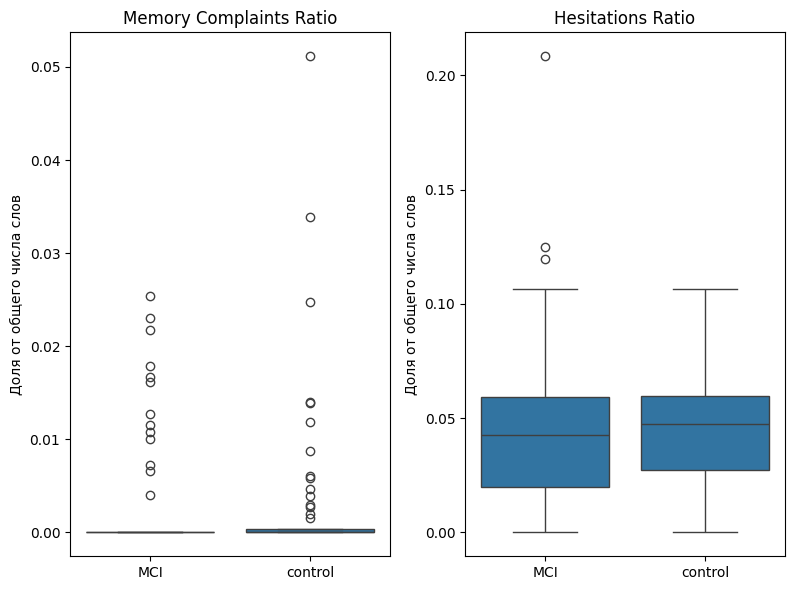


Анализ завершен. Результаты сохранены в папке final_analysis

Сводная статистика по группам:
                       mean                 std            min          \
group                   MCI   control       MCI   control  MCI control   
category                                                                 
hesitations        0.045630  0.048426  0.036926  0.028192  0.0     0.0   
memory_complaints  0.003064  0.003134  0.006595  0.008762  0.0     0.0   

                        max              median             n          
group                   MCI   control       MCI   control MCI control  
category                                                               
hesitations        0.208333  0.106509  0.042769  0.047486  60      60  
memory_complaints  0.025424  0.051163  0.000000  0.000000  60      60  

Результаты проверки значимости:
            category    test  statistic   p_value  significant
0  memory_complaints  U-тест     1773.5  0.853927        False
1        hesitat

In [24]:
def read_text_file(filename)    try:
        with open(filename, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        with open(filename, 'r', encoding='cp1251') as file:
             return file.read()
def clean_cha_text(text):
    return '\n'.join(line for line in text.split('\n') if not line.startswith('*INV:'))

def clean_utterance_text(text):
    # Удаление вставок интервьюера и технических меток
    text = re.sub(r'&\*INV:[^\s]*\s*\([^)]*\)', '', text)
    text = re.sub(r'&\S*\s*', '', text)
    
    # Удаление временных меток (форматы •123_456• и 123_456)
    text = re.sub(r'[•]\d+_\d+[•]', '', text)
    # Удаление специальных символов
    text = re.sub(r'[↫_*=!+…]', '', text)
    
    # Удаление английских слов (только слова из латинских букв)
    text = re.sub(r'\b[a-zA-Z]+\b', '', text)
    
    return text.strip()

def final_clean(text):
    # Удаление специальных символов и пунктуации
    text = re.sub(r'[\[\]<>&@,\/\\]', ' ', text)
    text = re.sub(r'\(\S+\)', '', text)  # Удаление комментариев в скобках
    
    # Удаление лишней пунктуации (кроме .!?)
    text = re.sub(r'[",:;=!+…]', '', text)
    
    # Удаление одиночных цифр и остатков меток
    text = re.sub(r'\b\d+\b', '', text)
    
    # Нормализация пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_utterances(text):
    cleaned_text = clean_cha_text(text)
    utterances = []
    current_utterance = []
    
    for line in cleaned_text.split('\n'):
        if line.startswith('*PAR:'):
            if current_utterance:
                full_utterance = ' '.join(current_utterance)
                utterances.append(full_utterance)
                current_utterance = []
            
            par_text = re.sub(r'^\*PAR:\s*', '', line)
            par_text = clean_utterance_text(par_text)
            current_utterance.append(par_text)
        elif current_utterance and not line.startswith('*'):
            cont_text = clean_utterance_text(line)
            current_utterance.append(cont_text)
            if current_utterance:
                full_utterance = ' '.join(current_utterance)
                utterances.append(full_utterance)
    
    final_utterances = []
    for utterance in utterances:
        sentences = re.split(r'(?<=[.!?…]) +', utterance)
        for sent in sentences:
            sent = final_clean(sent)
            if sent:
                final_utterances.append(sent)
    
    return final_utterances
def count_words(utterances):
    word_count = 0
    for utterance in utterances:
        cleaned_text = re.sub(r'[^\w\s\']', '', utterance)
        cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)
        words = [word for word in cleaned_text.split() if word]
        word_count += len(words)
    return word_count

def find_phrases(utterance, phrase_list, regex_list):
    utterance_lower = utterance.lower()
    found_phrases = set()
    # Поиск точных совпадений
    for phrase in phrase_list:
        if re.search(r'\b' + re.escape(phrase) + r'\b', utterance_lower):
            found_phrases.add(phrase)
    
    # Поиск по регулярным выражениям
    for pattern in regex_list:
        matches = re.finditer(pattern, utterance_lower)
        for match in matches:
            matched_text = match.group()
            is_new = True
            for phrase in phrase_list:
                if phrase in matched_text and phrase in found_phrases:
                    is_new = False
                    break
            if is_new:
                found_phrases.add(f"REGEX:{pattern}")
    
    return found_phrases
def analyze_file(filepath, phrase_lists, regex_lists):
   # Анализ одного файла
    text = read_text_file(filepath)
    utterances = extract_utterances(text)
    total_words = count_words(utterances)
    
    results = {
        'total_words': total_words,
        'phrases': defaultdict(int),
         'examples': defaultdict(list)
    }
    
    for utterance in utterances:
        for category in phrase_lists.keys():
            found_phrases = find_phrases(
                utterance, 
                phrase_lists[category], 
                regex_lists[category]
            )
            for phrase in found_phrases:
                results['phrases'][(category, phrase)] += 1
                if len(results['examples'][category]) < 3:
                    results['examples'][category].append(utterance.strip())
    
    return results

def analyze_group(folder_path, group_name, phrase_lists, regex_lists):
    """Анализ всех файлов в группе с компактным сохранением примеров"""
    group_data = []
    examples_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.cha'):
            filepath = os.path.join(folder_path, filename)
            try:
                file_results = analyze_file(filepath, phrase_lists, regex_lists)
                
                # Основные данные
                record = {
                    'filename': filename,
                    'group': group_name,
                    'total_words': file_results['total_words']
                }
                
                # Подсчет показателей
                for category in phrase_lists.keys():
                    count = sum(v for (cat, phrase), v in file_results['phrases'].items() 
                              if cat == category)
                    record[f'{category}_count'] = count
                    record[f'{category}_ratio'] = count / file_results['total_words'] if file_results['total_words'] > 0 else 0
                
                group_data.append(record)
                
                # Обработка примеров - убираем дубликаты и группируем по категориям
                examples_dict = defaultdict(list)
                seen_examples = set()  # Для отслеживания уже добавленных примеров
                
                for category, examples in file_results['examples'].items():
                    for example in examples:
                        # Удаляем лишние пробелы и приводим к нижнему регистру для сравнения
                        clean_example = ' '.join(example.strip().lower().split())
                        if clean_example not in seen_examples:
                            examples_dict[category].append(example.strip())
                            seen_examples.add(clean_example)
                
                # Ограничиваем количество примеров до 3 на категорию
                for category in examples_dict:
                    examples_dict[category] = examples_dict[category][:3]
                
                # Добавляем в examples_data только если есть хотя бы один пример
                if examples_dict:
                    examples_data.append({
                        'filename': filename,
                        'group': group_name,
                        'examples': str(examples_dict)  # Сохраняем как строку-словарь
                    })
                        
            except Exception as e:
                print(f"Ошибка при обработке {filename}: {str(e)}")
    
    return pd.DataFrame(group_data), pd.DataFrame(examples_data)

def save_results(df_results, df_examples, stats_df, output_dir):
    """Сохранение результатов в компактном формате"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Сохраняем основные результаты
    df_results.to_csv(os.path.join(output_dir, 'detailed_results.csv'), index=False, encoding='utf-8-sig')
    
    # Сохраняем примеры в компактном формате
    if not df_examples.empty:
        df_examples.to_csv(os.path.join(output_dir, 'phrase_examples.csv'), 
                         index=False, 
                         encoding='utf-8-sig',
                         sep='\t')  # Используем табуляцию как разделитель
    
    # Сохраняем статистику
    stats_df.to_csv(os.path.join(output_dir, 'group_stats.csv'), encoding='utf-8-sig')
    stats_df.to_excel(os.path.join(output_dir, 'group_stats.xlsx'))

def check_normality(data, group_name):
    """Проверка нормальности распределения данных"""
    print(f"\nПроверка нормальности для группы {group_name}:")
    for col in ['total_words', 'memory_complaints_ratio', 'hesitations_ratio']:
        if col in data.columns:
            stat, p = shapiro(data[col])
            print(f"{col}: W = {stat:.3f}, p = {p:.4f} {'(нормальное)' if p > 0.05 else '(не нормальное)'}")

def plot_distributions(data, group_name):
    """Визуализация распределений показателей"""
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Распределение показателей для группы {group_name}', y=1.02)
    
    # Распределение общего количества слов
    plt.subplot(2, 2, 1)
    sns.histplot(data['total_words'], kde=True)
    plt.title('Общее количество слов')
    plt.xlabel('Количество слов')
    plt.ylabel('Частота')
    
    # Распределение жалоб на память
    plt.subplot(2, 2, 2)
    sns.histplot(data['memory_complaints_ratio'], kde=True)
    plt.title('Доля жалоб на память')
    plt.xlabel('Доля от общего числа слов')
    plt.ylabel('Частота')
    
    # Распределение пауз неопределенности
    plt.subplot(2, 2, 4)
    sns.histplot(data['hesitations_ratio'], kde=True)
    plt.title('Доля пауз неопределенности')
    plt.xlabel('Доля от общего числа слов')
    plt.ylabel('Частота')
    
    plt.tight_layout()
    plt.show()

def compare_groups_boxplot(mci_data, control_data):
    """Сравнение групп с помощью boxplot"""
    categories = ['memory_complaints_ratio','hesitations_ratio']
    
    plt.figure(figsize=(12, 6))
    for i, category in enumerate(categories, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x='group', y=category, 
                   data=pd.concat([
                       mci_data[['group', category]],
                       control_data[['group', category]]
                   ]))
        plt.title(category.replace('_', ' ').title())
        plt.xlabel('')
        plt.ylabel('Доля от общего числа слов')
    
    plt.tight_layout()
    plt.show()

def calculate_statistics(df_results, phrase_lists):
    """Расчёт статистики по группам с проверкой значимости"""
    stats_data = []
    significance_results = []
    
    for group in ['MCI', 'control']:
        group_df = df_results[df_results['group'] == group]
        for category in phrase_lists.keys():
            ratios = group_df[f'{category}_ratio']
            
            if len(ratios) > 0:
                stats_data.append({
                    'group': group,
                    'category': category,
                    'mean': ratios.mean(),
                    'std': ratios.std(),
                    'min': ratios.min(),
                    'max': ratios.max(),
                    'median': ratios.median(),
                    'n': len(ratios)
                })
    
    # Проверка статистической значимости различий
    for category in phrase_lists.keys():
        mci_ratios = df_results[df_results['group'] == 'MCI'][f'{category}_ratio']
        control_ratios = df_results[df_results['group'] == 'control'][f'{category}_ratio']
        
        if len(mci_ratios) > 1 and len(control_ratios) > 1:
            # Проверка нормальности для выбора теста
            _, p_mci = shapiro(mci_ratios)
            _, p_control = shapiro(control_ratios)
            
            if p_mci > 0.05 and p_control > 0.05:
                # Если оба распределения нормальные - t-тест
                stat, p_value = ttest_ind(mci_ratios, control_ratios)
                test_name = "t-тест"
            else:
                # Если хотя бы одно распределение не нормальное - U-тест
                stat, p_value = mannwhitneyu(mci_ratios, control_ratios)
                test_name = "U-тест"
            
            significance_results.append({
                'category': category,
                'test': test_name,
                'statistic': stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })
            
            print(f"\nКатегория: {category}")
            print(f"MCI (n={len(mci_ratios)}): среднее = {mci_ratios.mean():.4f} ± {mci_ratios.std():.4f}")
            print(f"Контроль (n={len(control_ratios)}): среднее = {control_ratios.mean():.4f} ± {control_ratios.std():.4f}")
            print(f"{test_name}: статистика = {stat:.3f}, p-value = {p_value:.4f}")
            print("Различия значимы (p < 0.05)" if p_value < 0.05 else "Различия не значимы")
    
    stats_df = pd.DataFrame(stats_data).pivot(index='category', columns='group')
    significance_df = pd.DataFrame(significance_results)
    
    return stats_df, significance_df

def plot_significance(significance_df):
    """Визуализация значимости различий"""
    if not significance_df.empty:
        plt.figure(figsize=(10, 4))
        sns.barplot(x='category', y='p_value', hue='significant', data=significance_df)
        plt.axhline(0.05, color='red', linestyle='--')
        plt.title('Статистическая значимость различий между группами')
        plt.ylabel('p-value')
        plt.xlabel('Категория')
        plt.xticks(rotation=45)
        plt.legend(title='Значимо')
        plt.tight_layout()
        plt.show()

def main():
    phrase_lists = {
    'memory_complaints': [
        "забыл", "забыла", "забывать", "не помню", "не помнит", 
        "не вспомню", "не вспомнишь", "вспомнить не могу", "не могу вспомнить",
        "вылетело из головы", "выпало из памяти", "память подводит", 
        "память ухудшается", "все время забываю", "постоянно забываю", 
        "опять забыл", "теряю нить разговора", "сложно запомнить", 
        "ничего не прояснилось", "не могу придумать", "даже не помню", 
        "уже не помню", "не знаю", "не знаю что рассказать", "память напрячь", 
        "не припомню", "вспомнила что вспомнила",
        "у меня с памятью плохо", "вспоминается с трудом", "с трудом вспоминаю",
        "не помнится", "всё смешалось", "в голове каша", "не осталось в памяти",
        "помню смутно", "смутные воспоминания", "помню нечетко", "не получается вспомнить", "всё как в тумане", 
        "многое стёрлось из памяти", "всплывает не сразу", 
        "долго вспоминал", "еле вспомнил", "не могу связать в голове", 
        "было давно, уже не вспомню", "кажется, было что-то, но не помню",
        "вроде было, но не вспомню", "память уже не та", "возраст дает о себе знать", "старею, видимо", 
        "в мои годы память уже не держит", "всё забывается", 
        "всё уходит из головы", "раньше помнил, а сейчас — хоть убей", 
        "вылетает всё из головы", "память дырявая стала", "как сквозь пальцы уходит", "ничего не удерживается", "тяжело говорить", "сложно говорить", "не могу выразить", 
        "не получается объяснить", "не могу сформулировать",
        "мысль не идет", "в голове пусто", "рассказывать нечего", 
        "это сложно", "мысли путаются", "трудно собраться с мыслями",
        "не укладывается в голове", "теряюсь", "путаюсь", 
        "сбился с мысли", "не знаю с чего начать", 
        "не могу сосредоточиться на рассказе", "тяжело связать слова", "всё как сквозь туман", "где-то в глубине памяти", "вспоминаю по крупицам", "не помню когда это было", "давно это было — не вспомню", 
        "в каком году — не скажу", "всё слилось в одно", 
        "время тогда по-другому шло", "всё перепуталось", 
        "не могу привязать ко времени", "не различаю годы", 
        "годы путаются", "не знаю сколько лет прошло", 
        "не понимаю когда это было",
        "как сказать", "как это сказать", "как назвать", 
        "как он называется", "как они называются", "как это называется",
        "слово вертится на языке", "не могу подобрать слово", 
        "не могу вспомнить слово", "не знаю как назвать", 
        "не знаю как сказать", "не знаю что сказать",
        "как его", "слово на букву", "ну как его", 
        "как сказать правильно", "забыл слово", 
        "не могу выразить мысль", "не могу подобрать нужное слово",
        "вылетело слово", "не крутится в голове", 
        "ищу нужное слово", "никак не подберу нужное слово", 
        "не знаю, как это сформулировать", "не нахожу слов"
    ],
         'hesitations': [
        "ну", "это", "как его", "вот", "такой", "как бы", 
        "черт знает", "даже не знаю", "надо подумать",
        "так сразу и не скажешь", "надо время чтобы вспомнить",
        "не уверен", "не уверена", "сомневаюсь", "может быть",
        "вроде", "наверное", "пожалуй", "скорее всего", 
        "по-моему", "возможно", "затрудняюсь сказать", 
        "не могу точно сказать", "не уверен точно", "на вскидку не скажу"
    ]
}
    regex_lists = {
    'memory_complaints': [
        r"\bне\s*[^\s]{0,5}\s*помн[ияю]\w*",
        r"\bзабы[вл]\w*",
        r"\bпамят[ьи]\s*подвод\w+",
        r"\bвылетело\s*из\s*головы",
        r"\bне\s*мог[у]?\s*вспомн\w+",
        r"\bв\s*голове\s*пус\w+",
        r"\bсложн[оа]\s*запомн\w+",
        r"\bниче?го\s*не\s*помню",
        r"\bсмутн\w+\s*воспоминани\w*",
        r"\bне\s*припомн\w+",
        r"\bвсё\s*смешал\w*",
         r"\bв\s*голове\s*каша",
        r"\bне\s*остал\w+\s*в\s*памяти",
        r"\bеле\s*вспомн\w+",
        r"\bне\s*помнит[ся]?",
        r"\bкак\s*в\s*тумане",
        r"\bстёрлось\s*из\s*памяти"
        r"\bпамять\s+уже\s+не\s+та\b",
        r"\bвозраст\s+дает\s+о\s*себе\s*знать\b",
        r"\bстарею\b",
        r"\bв\s*мои\s*годы\s+память\s+уже\s+не\s+держит\b",
        r"\bвсё\s+забыва[ею]тся\b",
        r"\bуходит\s+из\s+головы\b",
        r"\bхоть\s+убей\s+не\s+вспомн\w+\b",
        r"\bвылетает\s+всё\s+из\s+головы\b",
        r"\bпамять\s+дыряв\w+\b",
        r"\bничего\s+не\s+удерживается\b",
        r"\bстарческ\w+\s+маразм\b",
        r"\bвспоминаю\s+по\s+крупицам\b",
        r"\bвсё\s+как\s+в\s+тумане\b",
        r"\bрасплыва\w+\s+воспоминан\w*",
        r"\b(тяжело|сложно)\s*(говорить|сказать)",
        r"\bне\s*мог[у]?\s*выраз\w+",
        r"\bмысль\s*не\s*идет",
        r"\bв\s*голове\s*пусто",
        r"\bне\s*получается\s*объясн\w+",
        r"\bне\s*мог[у]?\s*сформулиров\w+",
        r"\bмысли\s*пута\w+",
        r"\bтрудно\s*собраться\s*с\s*мыслями",
        r"\bне\s+помню\s+когда\s+это\s+было\b",
        r"\bв\s+каком\s+году.*не\s+(скажу|вспомню)\b",
        r"\bвсё\s+(перепуталось|слилось\s+в\s+одно)\b",
        r"\bне\s+могу\s+привязать\s+ко\s+времени\b",
        r"\bгоды\s+пута\w+\b",
        r"\bне\s+зна[юю]\s+сколько\s+лет\s+прошло\b",
        r"\bвремя\s+тогда\s+по-другому\s+шло\b"
        r"\bкак\s*(его|сказать|назвать|говорить)\b",
        r"\bне\s*мог[у]?\s*(вспомн\w+|подобрать)\s*(нужн\w+\s*)?(слово|слова)",
        r"\bслово\s*вертится\s*на\s*языке",
        r"\bне\s*зна[юю]\s*как\s*(сказать|говорить)",
        r"\bподобрать\s*(нужн\w*\s*)?слово",
        r"\bне\s*нахож\w+\s*слов",
        r"\bвылетело\s*слово",
        r"\bищу\s*нужн\w*\s*слово"
    ],
        'hesitations': [
        r"\b(ну|это|вот|как бы)\b",
        r"\bне\s*уверен\w*",
        r"\b(может быть|наверное|возможно)",
        r"\bнадо\s*подумать",
        r"\bтак\s*сразу\s*и\s*не\s*(скажешь|говоришь)",
        r"\bпо\s*моему",
        r"\bзатрудня\w*\s*(сказать|говорить)",
        r"\bне\s*мог[у]?\s*точно\s*(сказать|говорить)"
    ]
}
    
    output_dir = 'final_analysis'
    os.makedirs(output_dir, exist_ok=True)
    
    print("Анализ группы MCI...")
    df_mci, examples_mci = analyze_group('MCI - данные', 'MCI', phrase_lists, regex_lists)
    check_normality(df_mci, 'MCI')
    plot_distributions(df_mci, 'MCI')
    
    print("\nАнализ контрольной группы...")
    df_control, examples_control = analyze_group('Контроль-группа данные', 'control', phrase_lists, regex_lists)
    check_normality(df_control, 'Control')
    plot_distributions(df_control, 'Control')
    
    df_all_results = pd.concat([df_mci, df_control], ignore_index=True)
    df_all_examples = pd.concat([examples_mci, examples_control], ignore_index=True)
    
    stats_df, significance_df = calculate_statistics(df_all_results, phrase_lists)
    plot_significance(significance_df)
    compare_groups_boxplot(df_mci, df_control)
    
    # Сохранение результатов
    stats_df.to_csv(os.path.join(output_dir, 'group_stats.csv'), encoding='utf-8-sig')
    significance_df.to_csv(os.path.join(output_dir, 'significance_results.csv'), encoding='utf-8-sig')
    df_all_results.to_csv(os.path.join(output_dir, 'detailed_results.csv'), index=False, encoding='utf-8-sig')
    df_all_examples.to_csv(os.path.join(output_dir, 'phrase_examples.csv'), index=False, encoding='utf-8-sig')
    
    print("\nАнализ завершен. Результаты сохранены в папке", output_dir)
    print("\nСводная статистика по группам:")
    print(stats_df)
    print("\nРезультаты проверки значимости:")
    print(significance_df)

if __name__ == "__main__":
    main()

Основной код для анализа групп пациентов с синдромом МКС и при здоровом когнитивном старении (n=100)

Анализ группы MCI...

Проверка нормальности для группы MCI:
total_words: W = 0.698, p = 0.0000 (не нормальное)
memory_complaints_ratio: W = 0.489, p = 0.0000 (не нормальное)
hesitations_ratio: W = 0.883, p = 0.0000 (не нормальное)


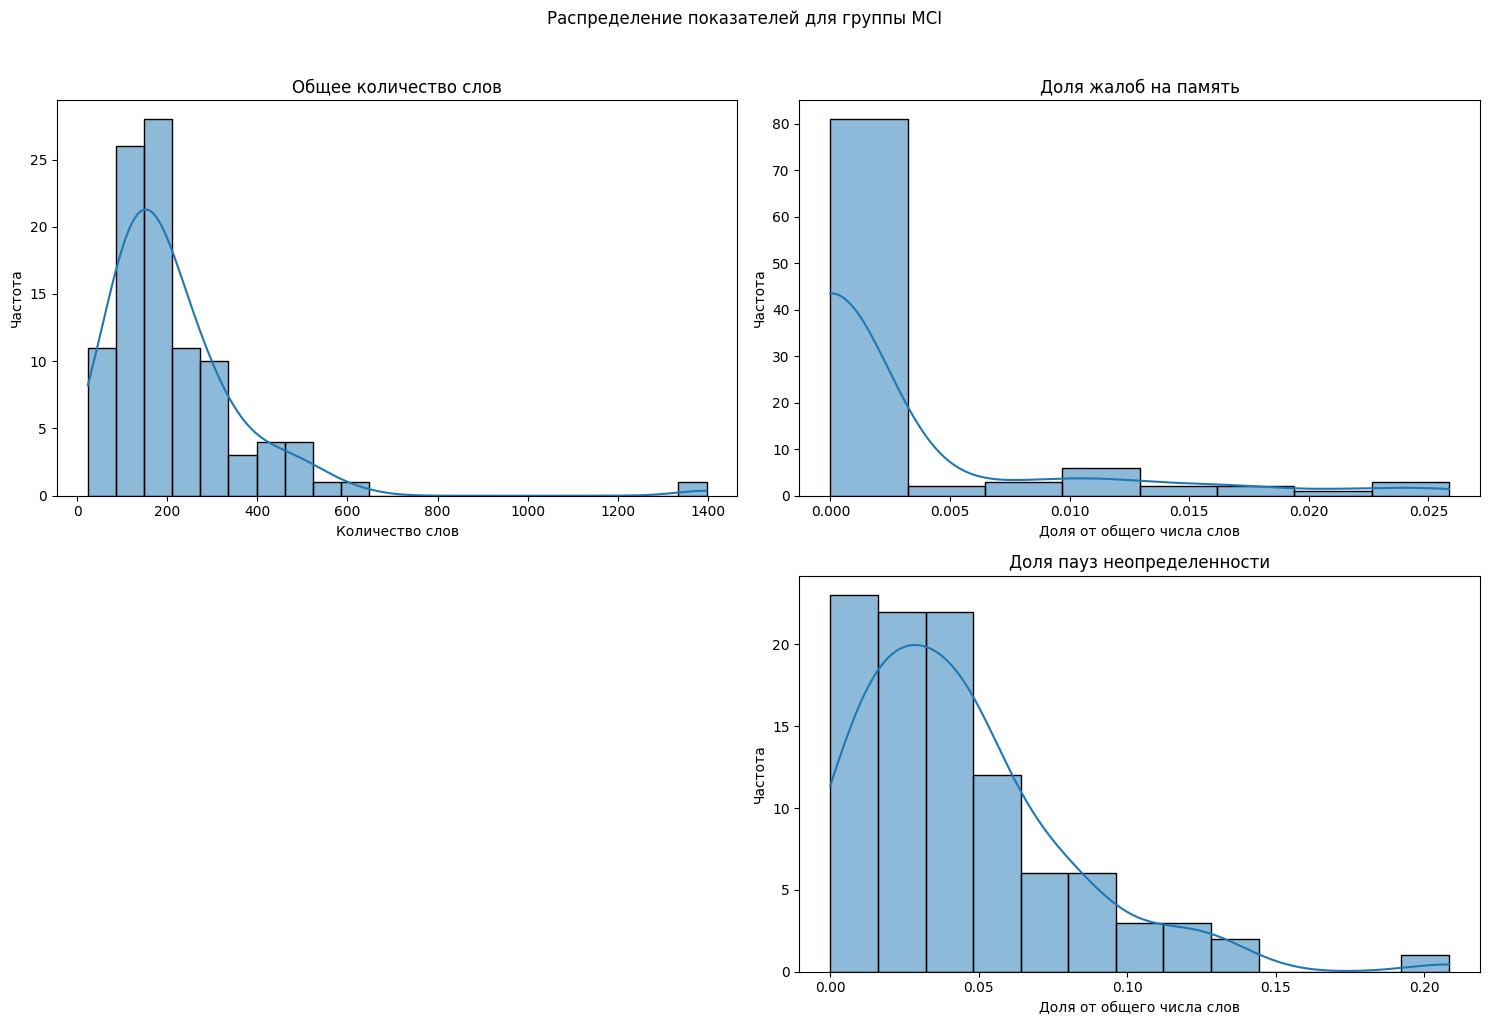


Анализ контрольной группы...

Проверка нормальности для группы Control:
total_words: W = 0.827, p = 0.0000 (не нормальное)
memory_complaints_ratio: W = 0.357, p = 0.0000 (не нормальное)
hesitations_ratio: W = 0.961, p = 0.0051 (не нормальное)


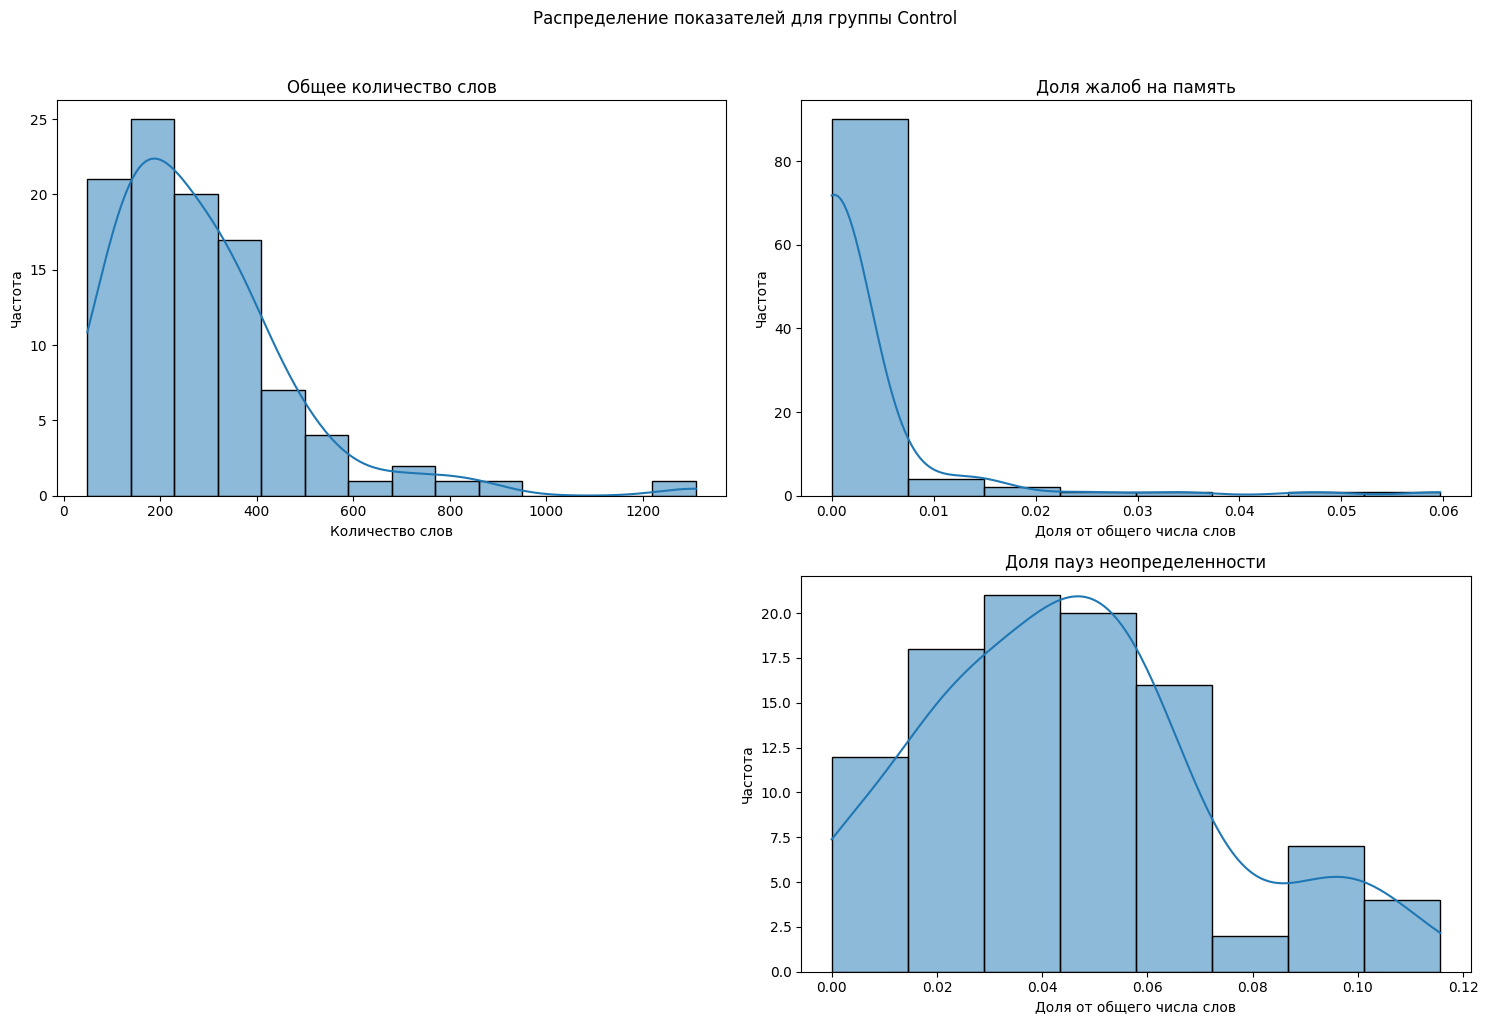


Категория: memory_complaints
MCI (n=100): среднее = 0.0026 ± 0.0061
Контроль (n=100): среднее = 0.0028 ± 0.0090
U-тест: статистика = 4958.500, p-value = 0.8860
Различия не значимы

Категория: hesitations
MCI (n=100): среднее = 0.0434 ± 0.0362
Контроль (n=100): среднее = 0.0445 ± 0.0276
U-тест: статистика = 4527.000, p-value = 0.2481
Различия не значимы


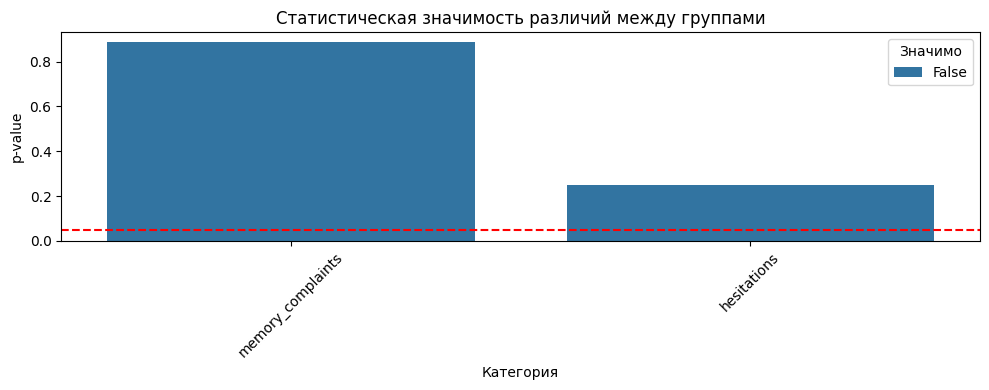

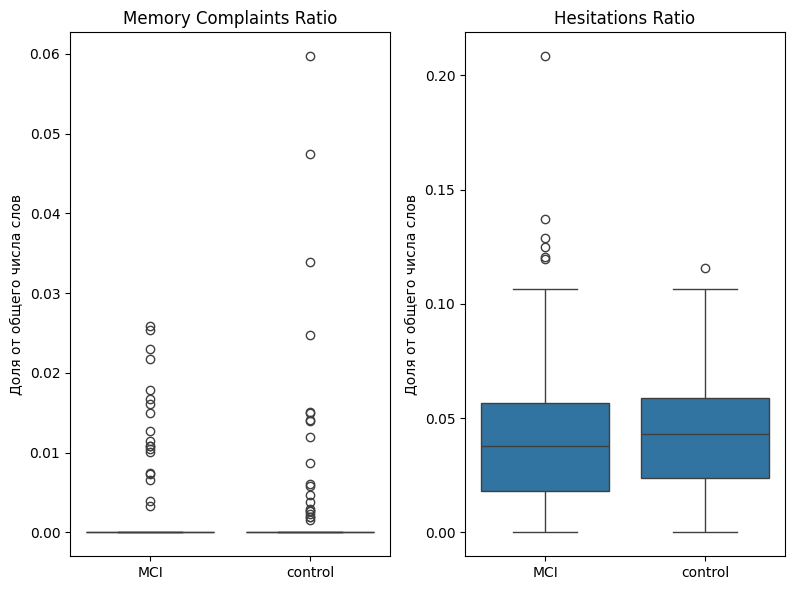


Анализ завершен. Результаты сохранены в папке final_analysis_100

Сводная статистика по группам:
                       mean                 std            min          \
group                   MCI   control       MCI   control  MCI control   
category                                                                 
hesitations        0.043431  0.044544  0.036185  0.027576  0.0     0.0   
memory_complaints  0.002568  0.002809  0.006079  0.008983  0.0     0.0   

                        max              median              n          
group                   MCI   control       MCI   control  MCI control  
category                                                                
hesitations        0.208333  0.115672  0.037914  0.042881  100     100  
memory_complaints  0.025862  0.059701  0.000000  0.000000  100     100  

Результаты проверки значимости:
            category    test  statistic   p_value  significant
0  memory_complaints  U-тест     4958.5  0.885971        False
1      

In [26]:
if __name__ == "__main__":
    phrase_lists = {
    'memory_complaints': [
        "забыл", "забыла", "забывать", "не помню", "не помнит", 
        "не вспомню", "не вспомнишь", "вспомнить не могу", "не могу вспомнить",
        "вылетело из головы", "выпало из памяти", "память подводит", 
        "память ухудшается", "все время забываю", "постоянно забываю", 
        "опять забыл", "теряю нить разговора", "сложно запомнить", 
        "ничего не прояснилось", "не могу придумать", "даже не помню", 
        "уже не помню", "не знаю", "не знаю что рассказать", "память напрячь", 
        "не припомню", "вспомнила что вспомнила",
        "у меня с памятью плохо", "вспоминается с трудом", "с трудом вспоминаю",
        "не помнится", "всё смешалось", "в голове каша", "не осталось в памяти",
        "помню смутно", "смутные воспоминания", "помню нечетко", "не получается вспомнить", "всё как в тумане", 
        "многое стёрлось из памяти", "всплывает не сразу", 
        "долго вспоминал", "еле вспомнил", "не могу связать в голове", 
        "было давно, уже не вспомню", "кажется, было что-то, но не помню",
        "вроде было, но не вспомню", "память уже не та", "возраст дает о себе знать", "старею, видимо", 
        "в мои годы память уже не держит", "всё забывается", 
        "всё уходит из головы", "раньше помнил, а сейчас — хоть убей", 
        "вылетает всё из головы", "память дырявая стала", "как сквозь пальцы уходит", "ничего не удерживается", "тяжело говорить", "сложно говорить", "не могу выразить", 
        "не получается объяснить", "не могу сформулировать",
        "мысль не идет", "в голове пусто", "рассказывать нечего", 
        "это сложно", "мысли путаются", "трудно собраться с мыслями",
        "не укладывается в голове", "теряюсь", "путаюсь", 
        "сбился с мысли", "не знаю с чего начать", 
        "не могу сосредоточиться на рассказе", "тяжело связать слова", "всё как сквозь туман", "где-то в глубине памяти", "вспоминаю по крупицам", "не помню когда это было", "давно это было — не вспомню", 
        "в каком году — не скажу", "всё слилось в одно", 
        "время тогда по-другому шло", "всё перепуталось", 
        "не могу привязать ко времени", "не различаю годы", 
        "годы путаются", "не знаю сколько лет прошло", 
        "не понимаю когда это было",
        "как сказать", "как это сказать", "как назвать", 
        "как он называется", "как они называются", "как это называется",
        "слово вертится на языке", "не могу подобрать слово", 
        "не могу вспомнить слово", "не знаю как назвать", 
        "не знаю как сказать", "не знаю что сказать",
        "как его", "слово на букву", "ну как его", 
        "как сказать правильно", "забыл слово", 
        "не могу выразить мысль", "не могу подобрать нужное слово",
        "вылетело слово", "не крутится в голове", 
        "ищу нужное слово", "никак не подберу нужное слово", 
        "не знаю, как это сформулировать", "не нахожу слов"
    ],
         'hesitations': [
        "ну", "это", "как его", "вот", "такой", "как бы", 
        "черт знает", "даже не знаю", "надо подумать",
        "так сразу и не скажешь", "надо время чтобы вспомнить",
        "не уверен", "не уверена", "сомневаюсь", "может быть",
        "вроде", "наверное", "пожалуй", "скорее всего", 
        "по-моему", "возможно", "затрудняюсь сказать", 
        "не могу точно сказать", "не уверен точно", "на вскидку не скажу"
    ]
}
    regex_lists = {
    'memory_complaints': [
        r"\bне\s*[^\s]{0,5}\s*помн[ияю]\w*",
        r"\bзабы[вл]\w*",
        r"\bпамят[ьи]\s*подвод\w+",
        r"\bвылетело\s*из\s*головы",
        r"\bне\s*мог[у]?\s*вспомн\w+",
        r"\bв\s*голове\s*пус\w+",
        r"\bсложн[оа]\s*запомн\w+",
        r"\bниче?го\s*не\s*помню",
        r"\bсмутн\w+\s*воспоминани\w*",
        r"\bне\s*припомн\w+",
        r"\bвсё\s*смешал\w*",
         r"\bв\s*голове\s*каша",
        r"\bне\s*остал\w+\s*в\s*памяти",
        r"\bеле\s*вспомн\w+",
        r"\bне\s*помнит[ся]?",
        r"\bкак\s*в\s*тумане",
        r"\bстёрлось\s*из\s*памяти"
        r"\bпамять\s+уже\s+не\s+та\b",
        r"\bвозраст\s+дает\s+о\s*себе\s*знать\b",
        r"\bстарею\b",
        r"\bв\s*мои\s*годы\s+память\s+уже\s+не\s+держит\b",
        r"\bвсё\s+забыва[ею]тся\b",
        r"\bуходит\s+из\s+головы\b",
        r"\bхоть\s+убей\s+не\s+вспомн\w+\b",
        r"\bвылетает\s+всё\s+из\s+головы\b",
        r"\bпамять\s+дыряв\w+\b",
        r"\bничего\s+не\s+удерживается\b",
        r"\bстарческ\w+\s+маразм\b",
        r"\bвспоминаю\s+по\s+крупицам\b",
        r"\bвсё\s+как\s+в\s+тумане\b",
        r"\bрасплыва\w+\s+воспоминан\w*",
        r"\b(тяжело|сложно)\s*(говорить|сказать)",
        r"\bне\s*мог[у]?\s*выраз\w+",
        r"\bмысль\s*не\s*идет",
        r"\bв\s*голове\s*пусто",
        r"\bне\s*получается\s*объясн\w+",
        r"\bне\s*мог[у]?\s*сформулиров\w+",
        r"\bмысли\s*пута\w+",
        r"\bтрудно\s*собраться\s*с\s*мыслями"
        r"\bне\s+помню\s+когда\s+это\s+было\b",
        r"\bв\s+каком\s+году.*не\s+(скажу|вспомню)\b",
        r"\bвсё\s+(перепуталось|слилось\s+в\s+одно)\b",
        r"\bне\s+могу\s+привязать\s+ко\s+времени\b",
        r"\bгоды\s+пута\w+\b",
        r"\bне\s+зна[юю]\s+сколько\s+лет\s+прошло\b",
        r"\bвремя\s+тогда\s+по-другому\s+шло\b",
        r"\bкак\s*(его|сказать|назвать|говорить)\b",
        r"\bне\s*мог[у]?\s*(вспомн\w+|подобрать)\s*(нужн\w+\s*)?(слово|слова)",
        r"\bслово\s*вертится\s*на\s*языке",
        r"\bне\s*зна[юю]\s*как\s*(сказать|говорить)",
        r"\bподобрать\s*(нужн\w*\s*)?слово",
        r"\bне\s*нахож\w+\s*слов",
        r"\bвылетело\s*слово",
        r"\bищу\s*нужн\w*\s*слово"
    ],
        'hesitations': [
        r"\b(ну|это|вот|как бы)\b",
        r"\bне\s*уверен\w*",
        r"\b(может быть|наверное|возможно)",
        r"\bнадо\s*подумать",
        r"\bтак\s*сразу\s*и\s*не\s*(скажешь|говоришь)",
        r"\bпо\s*моему",
        r"\bзатрудня\w*\s*(сказать|говорить)",
        r"\bне\s*мог[у]?\s*точно\s*(сказать|говорить)"
    ]
}
    
    output_dir = 'final_analysis_100'
    os.makedirs(output_dir, exist_ok=True)
    
    print("Анализ группы MCI...")
    df_mci, examples_mci = analyze_group('MCI - данные_100', 'MCI', phrase_lists, regex_lists)
    check_normality(df_mci, 'MCI')
    plot_distributions(df_mci, 'MCI')
    
    print("\nАнализ контрольной группы...")
    df_control, examples_control = analyze_group('Контроль-группа данные_100', 'control', phrase_lists, regex_lists)
    check_normality(df_control, 'Control')
    plot_distributions(df_control, 'Control')
    
    df_all_results = pd.concat([df_mci, df_control], ignore_index=True)
    df_all_examples = pd.concat([examples_mci, examples_control], ignore_index=True)
    
    stats_df, significance_df = calculate_statistics(df_all_results, phrase_lists)
    plot_significance(significance_df)
    compare_groups_boxplot(df_mci, df_control)
    
    # Сохранение результатов
    stats_df.to_csv(os.path.join(output_dir, 'group_stats_100.csv'), encoding='utf-8-sig')
    significance_df.to_csv(os.path.join(output_dir, 'significance_results_100.csv'), encoding='utf-8-sig')
    df_all_results.to_csv(os.path.join(output_dir, 'detailed_results_100.csv'), index=False, encoding='utf-8-sig')
    df_all_examples.to_csv(os.path.join(output_dir, 'phrase_examples_100.csv'), index=False, encoding='utf-8-sig')
    
    print("\nАнализ завершен. Результаты сохранены в папке", output_dir)
    print("\nСводная статистика по группам:")
    print(stats_df)
    print("\nРезультаты проверки значимости:")
    print(significance_df)


